## COMP5625M Assessment 2 - Image Caption Generation

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your full name: Kritin Senaprame

### Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# from google.colab import drive
import re

Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
ROOT = "./COMP5625M_data_assessment_2/"

Using device: cpu


In [3]:
# drive.mount('/content/drive/')
# ROOT = "/content/drive/MyDrive/Colab Notebooks/COMP5625M_data_assessment_2/"

The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features

> 1.1 Design a encoder layer with pretrained ResNet50 

> 1.2 Image feature extraction step 

#### 1.1 Design a encoder layer with pretrained ResNet50

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [4]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resn = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2)
        self.net = nn.Sequential(*list(resn.children())[:-1])
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        features = self.net(images)
        features = features.view(features.size(0), -1)
        return features 


In [5]:
# instantiate encoder and put into evaluation mode.
Enc = EncoderCNN()
Enc.eval()

EncoderCNN(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

#### 1.2 Image feature extraction step

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [6]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [7]:
# Get unique images from the csv for extracting features - helper code
file_path = ROOT + "coco_subset_meta.csv"
imageList = pd.read_csv(file_path)
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
# df_unique_files

5068


In [8]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it 

IMAGE_DIR = ROOT + "/coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        img_loc = IMAGE_DIR + filename
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, filename

    def __len__(self):
        return len(self.df)
    

In [9]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise

data = COCOImagesDataset(df_unique_files, transform = data_transform)
data_loader = DataLoader(
    data,
    shuffle = False,
    batch_size = 64
)

In [10]:
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this

features_map = dict()
from tqdm.notebook import tqdm 
from PIL import Image

path = "./result/"
os.makedirs(path, exist_ok = True)
file_path = path + "features.pt"
with torch.no_grad():
    for data in data_loader:
        images, files = data
        images = images.to(device)
        features = Enc(images)
        IDs = tuple(int(file.replace(".jpg", "")) for file in files)
        for i,_ in enumerate(IDs):
            features_map[IDs[i]] = features[i]

    torch.save(features_map, file_path)

In [11]:
features_map[9].shape

torch.Size([2048])

## 2 Text preparation

> 2.1 Build the caption dataset

> 2.2 Clean the captions

> 2.3 Split the data

> 2.4 Building the vocabulary

> 2.5 Prepare dataset using dataloader


#### 2.1 Build the caption dataset

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [12]:
import json

# loading captions for training
file_path = ROOT + 'coco/annotations2017/captions_train2017.json'
with open(file_path, 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.sort_values(by=['image_id'])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [13]:
# Load "coco_subset_meta.csv"
file_path = ROOT + "coco_subset_meta.csv"
coco_subset = pd.read_csv(file_path)
coco_subset.rename(columns = {"id": "image_id"}, inplace = True)
coco_subset.drop_duplicates(subset = ['image_id'], inplace = True)

# Create new data frame
new_file = df.merge(coco_subset[["file_name", "image_id"]], how = 'right', on = "image_id", sort = True)
new_file.head()


,image_id,id,caption,file_name
0,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg
1,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg
2,9,663627,there are containers filled with different kin...,000000000009.jpg
3,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg
4,9,667602,A bunch of trays that have different food.,000000000009.jpg


#### 2.2 Clean the captions

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [14]:
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):

    # Remove spaces in the beginning and at the end
    # Convert to lower case
    # Replace all non-alphabet characters with space
    # Replace all continuous spaces with a single space
    clean_caption = df['caption'].str.strip()
    clean_caption = clean_caption.str.lower()
    clean_caption = clean_caption.str.replace('[^a-zA-Z]', ' ')
    clean_caption = clean_caption.str.replace(' +', ' ')
    
    # add to dataframe
    df["clean_caption"] = clean_caption

    return df

In [15]:
new_file.shape

(25349, 5)

In [16]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

/var/folders/ny/l3gkwgn53_vg_xl4hh6gvq640000gn/T/ipykernel_6583/272088528.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_caption = clean_caption.str.replace('[^a-zA-Z]', ' ')
/var/folders/ny/l3gkwgn53_vg_xl4hh6gvq640000gn/T/ipykernel_6583/272088528.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_caption = clean_caption.str.replace(' +', ' ')


,image_id,id,caption,file_name,clean_caption
0,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg,closeup of bins of food that include broccoli ...
1,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg,a meal is presented in brightly colored plasti...
2,9,663627,there are containers filled with different kin...,000000000009.jpg,there are containers filled with different kin...
3,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg,colorful dishes holding meat vegetables fruit ...
4,9,667602,A bunch of trays that have different food.,000000000009.jpg,a bunch of trays that have different food
5,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg,a giraffe eating food from the top of the tree
6,25,127076,A giraffe standing up nearby a tree,000000000025.jpg,a giraffe standing up nearby a tree
7,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg,a giraffe mother with its baby in the forest
8,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg,two giraffes standing in a tree filled area
9,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg,a giraffe standing next to a forest filled wit...


#### 2.3  Split the data

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [17]:
import random
import math

def split_ids(image_id_list, train=0.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [18]:
image_id_list = new_file['image_id'].unique()
train_id, valid_id, test_id = split_ids(image_id_list)


In [19]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)].reset_index(drop = True)
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)].reset_index(drop = True)
test_set = new_file.loc[new_file['image_id'].isin(test_id)].reset_index(drop = True)

In [20]:
print(len(train_set))
print(len(valid_set))
print(len(test_set))

17740
2531
5078


#### 2.4 Building the vocabulary

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [21]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [22]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        cap = new_file.loc[new_file['image_id']==id]['clean_caption']
        for index in cap.index.tolist():
            caption = str(cap[index])
            for word in caption.split():
                # also get rid of numbers, symbols etc.
                if word in word_mapping:
                    word_mapping[word] += 1
                else:
                    word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)
    return vocab


In [23]:
## build your vocabulary for train, valid and test sets
v = np.append(train_id, valid_id)
vocab = build_vocab(v, new_file)

In [24]:
print("Train and valid vocabulary are: {}".format(vocab.__len__()))

Train and valid vocabulary are: 2433


#### 2.5 Prepare dataset using dataloader

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [25]:
path = "./result/"
file_path = path + "features.pt"
features_map = torch.load(file_path)

In [26]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        self.df = df
        self.features = features
        self.vocab = vocab

    
    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        feature = self.features[self.df['image_id'][index]]
        feature = torch.unsqueeze(feature, 0)
        text = self.df['clean_caption'][index].split()
        text_tox = [self.vocab.word2idx['<unk>'] if not t in self.vocab.word2idx else self.vocab.word2idx[t] for t in text]
        text_tox.append(self.vocab.word2idx['<end>'])
        cap_len = len(text_tox)
        cap_len = torch.tensor(cap_len)
        text_tox.extend([vocab.word2idx['<pad>']] * (MAX_SEQ_LEN - cap_len))
        text_tox = torch.tensor(text_tox)
        
        return (feature, text_tox, cap_len)
    
    def __len__(self):
        return len(self.df)
    

In [27]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    batch_size = 64
    data.sort(key = lambda data: len(data[1]), reverse = True)
    _, _, lengths = zip(*data)
    # merge images (from tuple of 3D tensor to 4D tensor).
    # if using features, 2D tensor to 3D tensor. (batch_size, 256)
    images = torch.stack(list(zip(*data))[0], dim = 0)

    # merge captions (from tuple of 1D tensor to 2D tensor).
    captions = list(zip(*data))[1]
#     lengths = []
    targets = []
    for cap in captions:
        l = len(cap)
#         lengths.append(l)
        # pad with zeros
        target = list(cap) + [0] * (MAX_SEQ_LEN - l)
        targets.append(torch.tensor(target))
    targets = torch.stack(targets, dim = 0)

    return images, targets, lengths


In [28]:
dataset_train = COCO_Features(
    df = train_set,
    vocab = vocab,
    features = features_map,
)

#  your dataloader here (make shuffle true as you will be training RNN)
train_loader = DataLoader(
    dataset_train,
    shuffle = True,
    batch_size = 64,
    collate_fn = caption_collate_fn
)

# Do the same as above for your validation set
dataset_valid = COCO_Features(
    df = valid_set,
    vocab = vocab,
    features = features_map,
)

#  your dataloader here (make shuffle true as you will be training RNN)
valid_loader = DataLoader(
    dataset_valid,
    shuffle = False,
    batch_size = 64,
    collate_fn = caption_collate_fn
)

Load one batch of the training set and print out the shape of each returned Tensor.

In [29]:
print_first = iter(train_loader)
images, targets, lengths = next(print_first)
print('Images tensor shape: {0}\nTargers tenser shape: {1}\nLengths tenser shape: {2}'.format(images.shape, targets.shape, len(lengths)))


Images tensor shape: torch.Size([64, 1, 2048])
Targers tenser shape: torch.Size([64, 47])
Lengths tenser shape: 64


## 3 Train DecoderRNN 

> 3.1 Design RNN-based decoder

> 3.2 Train your model with precomputed features

#### 3.1 Design a RNN-based decoder

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [30]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer 
        # (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, 
        # other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.max_seq_length = max_seq_length
        
        
        self.resize = nn.Linear(2048, embed_size)
        
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size)

        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # your code for RNN
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first = True)

        # self.linear: linear layer with input: hidden layer, output: vocab size
        self.linear = nn.Linear(hidden_size, vocab_size)
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        features = self.resize(features)
        features = features.view(features.size(0), -1)
        im_features = self.bn(features)
        
        # compute your feature embeddings
        inputs = torch.cat((im_features.unsqueeze(1), embeddings), dim=1)
    
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed = pack_padded_sequence(inputs, lengths = lengths, batch_first = True, enforce_sorted=False)
#         print(packed.batch_sizes.shape)
        hiddens, _ = self.rnn(packed)

        outputs = self.linear(hiddens[0]) #hint: use a hidden layers in parenthesis
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [31]:
# instantiate decoder
rnn = DecoderRNN(vocab_size = vocab.__len__())


#### 3.2 Train your model with precomputed features 

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [32]:
from torch import optim

def stats(loader, model, loss_fn):
    correct = 0
    total = 0
    running_loss = 0
    n = 0
    with torch.no_grad():
        for images, captions, lengths in loader:
            targets = pack_padded_sequence(captions, lengths, batch_first = True, enforce_sorted=False)[0]
            outputs = model(images, captions, lengths)
            
            # accumulate loss
            running_loss += loss_fn(outputs, targets)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
    return running_loss/n, correct/total 


def train(model, nepochs = 25, lr = 0.001):
    path = "./result/"
    os.makedirs(path, exist_ok = True)
    file_path = path + "decoder.pt"
    statsrec = np.zeros((4, nepochs))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)

    for epoch in range(nepochs):
        correct = 0
        total = 0
        running_loss = 0.0
        n = 0
        for images, captions, lengths in train_loader:
            targets = pack_padded_sequence(captions, lengths, batch_first = True, enforce_sorted=False)[0]
            
            # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
            optimizer.zero_grad()

            # Forward, backward, and update parameters
            outputs = model(images, captions, lengths)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            # accumulate loss and increment minibatches
            running_loss += loss.item()
            n += 1

            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # collect together statistics for this epoch
        ltrn = running_loss / n
        atrn = correct/total 
        ltst, atst = stats(valid_loader, model, loss_fn)
        statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

    # save network parameters and losses
    torch.save({"state_dict": model.state_dict(), "stats": statsrec}, file_path)

In [33]:
train(rnn)

epoch: 0 training loss:  4.198 training accuracy:  30.2%  test loss:  3.493 test accuracy:  36.0%
epoch: 1 training loss:  3.105 training accuracy:  38.9%  test loss:  3.175 test accuracy:  38.6%
epoch: 2 training loss:  2.757 training accuracy:  42.4%  test loss:  3.073 test accuracy:  40.1%
epoch: 3 training loss:  2.527 training accuracy:  44.9%  test loss:  3.048 test accuracy:  40.5%
epoch: 4 training loss:  2.339 training accuracy:  47.2%  test loss:  3.060 test accuracy:  40.4%
epoch: 5 training loss:  2.179 training accuracy:  49.2%  test loss:  3.081 test accuracy:  40.4%
epoch: 6 training loss:  2.037 training accuracy:  51.2%  test loss:  3.111 test accuracy:  40.1%
epoch: 7 training loss:  1.904 training accuracy:  53.3%  test loss:  3.139 test accuracy:  40.4%
epoch: 8 training loss:  1.782 training accuracy:  55.3%  test loss:  3.197 test accuracy:  40.0%
epoch: 9 training loss:  1.667 training accuracy:  57.3%  test loss:  3.250 test accuracy:  39.8%
epoch: 10 training l

In [34]:
def fig_plot(result, name):
    fig = plt.figure()
    statsrec = result["stats"]
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[2], 'g', label = 'validation loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss, and validation accuracy')
    ax2=ax1.twinx()
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    fig_name = name + ".svg"
    fig.savefig(fig_name)
    plt.show()

<Figure size 432x288 with 0 Axes>

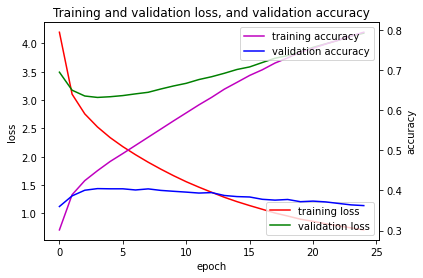

In [35]:
path = "./result/"
file_path = path + "decoder.pt"
train_result = torch.load(file_path)
fig_plot(result = train_result, name = 'train_result')

## 4 Generate predictions on test data

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [36]:
path = "./result/"
file_path = path + "features.pt"
features_map = torch.load(file_path)
file_path = path + "decoder.pt"
param = torch.load(file_path)

rnn = DecoderRNN(vocab_size = vocab.__len__())
rnn.load_state_dict(param['state_dict'])

<All keys matched successfully>


=== Picture 1 ===


/var/folders/ny/l3gkwgn53_vg_xl4hh6gvq640000gn/T/ipykernel_6583/1490915945.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features.append(torch.tensor(feature))


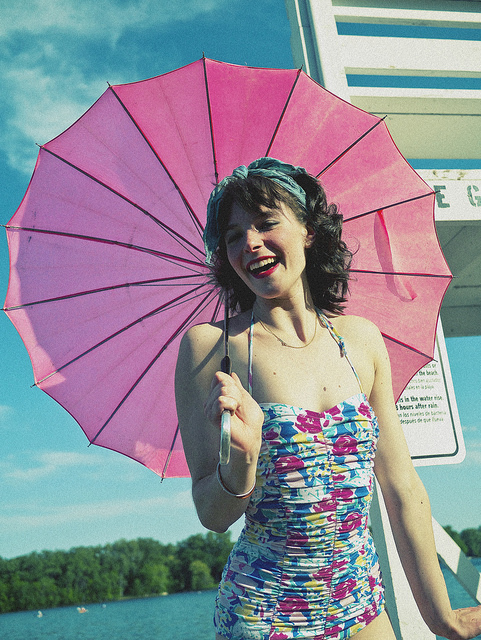

Caption 1: Woman in swim suit holding parasol on sunny day.
Caption 2: A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind.
Caption 3: A woman in a floral swimsuit holds a pink umbrella.
Caption 4: A woman with an umbrella near the sea
Caption 5: A girl in a bathing suit with a pink umbrella.

Generated caption: a woman holding an umbrella and having her picture of a woman


=== Picture 2 ===


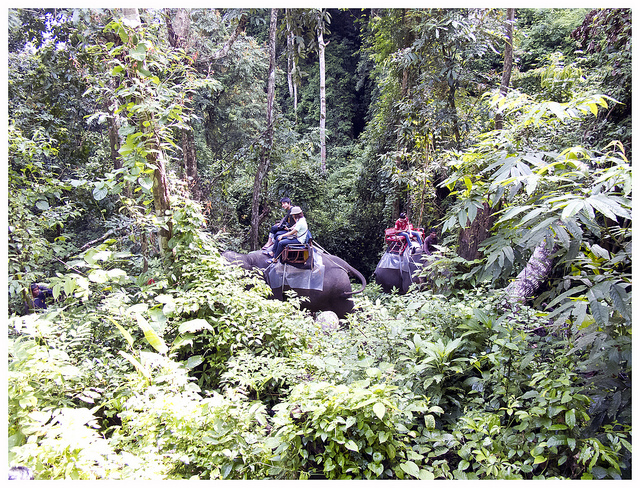

Caption 1: They are brave for riding in the jungle on those elephants.
Caption 2: SOME PEOPLE IN THE WOODS RIDING TWO ELEPHANTS
Caption 3: Some people who are riding on top of elephants.
Caption 4: there are people riding elephants in the middle of a forest
Caption 5: Several elephants in the jungle carrying people on their backs

Generated caption: a man on a snowboard on a mountain course


=== Picture 3 ===


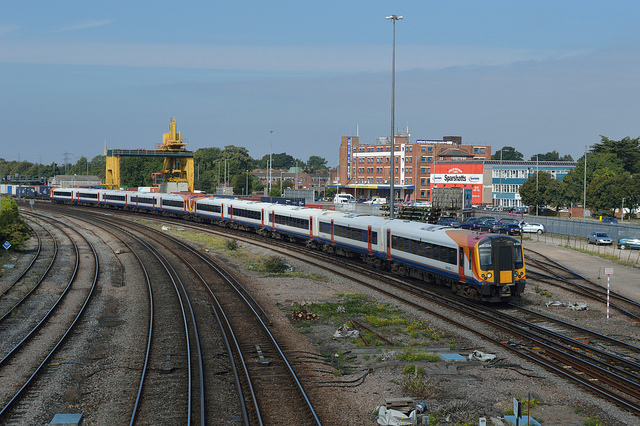

Caption 1: A train coming to a stop on the tracks out side.
Caption 2: The very long train is travelling down the tracks.
Caption 3: A passenger train glides around a curve on the outer track.
Caption 4: A train coming down the tracks in the city.
Caption 5: A train engine carrying many carts down a track.

Generated caption: a short commuter train at the station in the ocean


=== Picture 4 ===


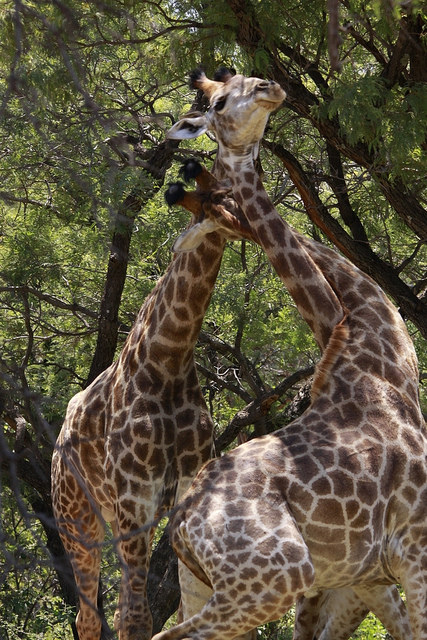

Caption 1: A couple of giraffe snuggling each other in a forest.
Caption 2: A couple of giraffe standing next to some trees.
Caption 3: Two Zebras seem to be embracing in the wild. 
Caption 4: Two giraffes hang out near trees and nuzzle up to each other.
Caption 5: The two giraffes appear to be hugging each other.

Generated caption: a close up of a stuffed animal near some trees


=== Picture 5 ===


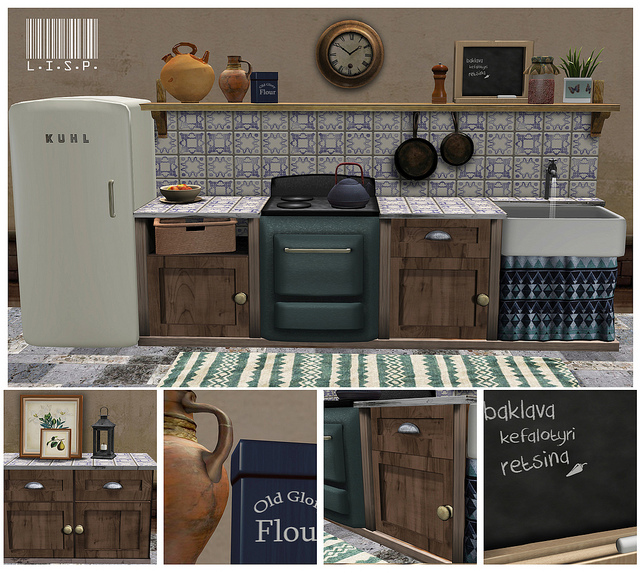

Caption 1: The kitchen has odd looking colors in it.
Caption 2: Picture of a kitchen this has smaller photos of item within that kitchen. 
Caption 3: Three dimensional rendering of a kitchen area with various appliances. 
Caption 4: A series of photographs of a tiny model kitchen
Caption 5: Collage of pictures from a clean rustic kitchen. 

Generated caption: a large white refrigerator a red and white counter top with pots and pans



In [37]:
from IPython.display import Image, display
images = test_set['file_name'].unique()[:5]

features = []
for image in images:
    x = int(image.replace(".jpg", ""))
    feature = features_map[x]
    features.append(torch.tensor(feature))
    
features = torch.stack(features, dim = 0)
outputs = rnn.sample(features)

for i, image in enumerate(images):
    print("\n=== Picture {} ===".format(i + 1))
    path = "./COMP5625M_data_assessment_2/coco/images/"
    file_path = path + image
    display(Image(filename = file_path, width = 300, height = 200))
    captions = list(test_set[test_set['file_name'] == image]['caption'])
    for j, cap in enumerate(captions):
        print("Caption {0}: {1}".format(j + 1, cap))
        
    cap_gen = []
    for w in outputs[i]:
        if vocab.idx2word[int(w)] != '<end>':
            cap_gen.append(vocab.idx2word[int(w)])
        else:
            break
    sen_gen = ' '.join(cap_gen)
    print("\nGenerated caption: {}\n".format(sen_gen))


## 5 Caption evaluation using BLEU score

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data

> 5.2 Examplaire high and low score BLEU score samples

####  5.1 Average BLEU score on all data


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [38]:
# TO COMPLETE
import warnings
warnings.filterwarnings("ignore")
from nltk.translate.bleu_score import sentence_bleu
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim']) # dict()

# --> Your code here!
images = test_set['file_name'].unique()
features = []
for image in images:
    x = int(image.replace(".jpg", ""))
    feature = features_map[x]
    features.append(torch.tensor(feature))
    
features = torch.stack(features, dim = 0)
outputs = rnn.sample(features)


for i, image in enumerate(images):
    ref_cap = list(test_set[test_set['file_name'] == image]['clean_caption'])    
    test_cap = []
    for w in outputs[i]:
        if vocab.idx2word[int(w)] != '<end>':
            test_cap.append(vocab.idx2word[int(w)])
        else:
            break
    test_cap = ' '.join(test_cap)
    
    bleu_score = sentence_bleu(ref_cap, test_cap)
    new_data = {'ref': ref_cap, 'preds': test_cap, 'bleu': bleu_score, 'cos_sim': None}
    stats = stats.append(new_data, ignore_index = True)

Average BLEU score: 0.5649489745246674


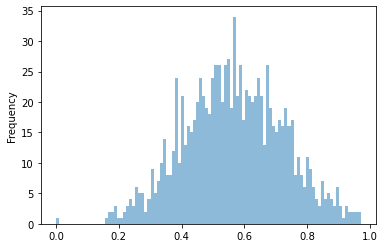

In [39]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins = 100, alpha = 0.5)

#### 5.2 Examplaire high and low score BLEU score samples

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [40]:
# TO COMPLETE
stats_sort = stats.sort_values('bleu').reset_index(drop=True)
last = stats_sort.shape[0] - 1

print("=== Highest BLEU score ===")
print("Predicted sentences: {}".format(stats_sort['preds'][last]))
print("BLEU scores: {:.3f}".format(stats_sort['bleu'][last]))
print("Reference captioons:")
for i, ref in enumerate(stats_sort['ref'][last]):
    print("{}. {}".format(i + 1, ref))

print("\n=== Lowest BLEU score ===")
print("Predicted sentences: {}".format(stats_sort['preds'][0]))
print("BLEU scores: {:.3f}".format(stats_sort['bleu'][0]))
print("Reference captioons:")
for i, ref in enumerate(stats_sort['ref'][0]):
    print("{}. {}".format(i + 1, ref))

=== Highest BLEU score ===
Predicted sentences: a plate of food that is on a table
BLEU scores: 0.971
Reference captioons:
1. a plate of food that is on a table 
2. a white plate topped with meat and vegetables 
3. grilled chicken and broccoli spears are loaded on a plate 
4. a large plate with two chicken fillets and veggies 
5. broccoli and chicken are served on a plate 

=== Lowest BLEU score ===
Predicted sentences: a toilet that has a tooth brush in it
BLEU scores: 0.000
Reference captioons:
1. three urinals are hanging from a marble tile wall
2. a view of three urinals next to each other 
3. three modern white urinals line up against a grey bathroom wall 
4. three urinals are handing from the wall of the bathroom
5. three urinals hanging on the wall of a public bathroom


## 6 Caption evaluation using cosine similarity

> 6.1 Cosine similarity

> 6.2 Cosine similarity examples

####  6.1 Cosine similarity

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [41]:
# TO COMPLETE
dataset_test = COCO_Features(
    df = test_set,
    vocab = vocab,
    features = features_map,
)

test_loader = DataLoader(
    dataset_test,
    shuffle = False,
    batch_size = 64,
    collate_fn = caption_collate_fn
)

ref_embed_avg = []
word_length = []
for img, fea, num in test_loader:
    ref_embed = rnn.embed(fea)
    avg = [torch.sum(emb[:num[i]], dim = 0) / num[i] for i, emb in enumerate(ref_embed)]
    word_length.extend(num)
    ref_embed_avg.extend(avg)
    
ref_avg = torch.stack(ref_embed_avg)

In [42]:
images = test_set['file_name']
features = []
for image in images:
    x = int(image.replace(".jpg", ""))
    feature = features_map[x]
    features.append(torch.tensor(feature))
    
features = torch.stack(features, dim = 0)
outputs = rnn.sample(features)

gen_embed_avg = []
for i, output in enumerate(outputs):
    gen_embed = rnn.embed(output)
    avg = torch.sum(gen_embed[:word_length[i]], dim = 0) / word_length[i]
    gen_embed_avg.append(avg)
    
gen_avg = torch.stack(gen_embed_avg)

Average of Cosine similarity: 0.37692052125930786


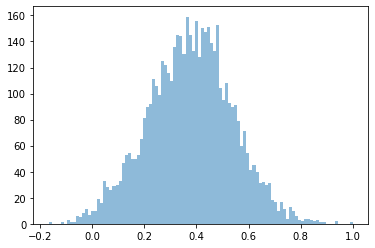

In [43]:
from torch.nn.functional import cosine_similarity

cosine_sim = cosine_similarity(ref_avg, gen_avg)
cosine_sim = cosine_sim.detach().numpy()
cosine_sim_avg = np.average(cosine_sim)
test = test_set.copy()
test['cos_sim'] = cosine_sim

print("Average of Cosine similarity: {}".format(cosine_sim_avg))
ax = plt.hist(cosine_sim , bins = 100, alpha = 0.5)

#### 6.2 Cosine similarity examples

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [50]:
# TO COMPLETE
test_avg = test.groupby('file_name').mean()
stats['cos_sim'] = test_avg['cos_sim'].values
stats_sort = stats.sort_values('bleu').reset_index(drop=True)
last = stats_sort.shape[0] - 1

print("=== High cosine-similarity score ===")
print("Predicted sentences: {}".format(stats_sort['preds'][last]))
print("BLEU scores: {:.3f}".format(stats_sort['cos_sim'][last]))
print("Reference captioons:")
for i, ref in enumerate(stats_sort['ref'][last]):
    print("{}. {}".format(i + 1, ref))

print("\n=== Low cosine-similarity score ===")
print("Predicted sentences: {}".format(stats_sort['preds'][0]))
print("BLEU scores: {:.3f}".format(stats_sort['cos_sim'][0]))
print("Reference captioons:")
for i, ref in enumerate(stats_sort['ref'][0]):
    print("{}. {}".format(i + 1, ref))

=== High cosine-similarity score ===
Predicted sentences: a plate of food that is on a table
BLEU scores: 0.479
Reference captioons:
1. a plate of food that is on a table 
2. a white plate topped with meat and vegetables 
3. grilled chicken and broccoli spears are loaded on a plate 
4. a large plate with two chicken fillets and veggies 
5. broccoli and chicken are served on a plate 

=== Low cosine-similarity score ===
Predicted sentences: a toilet that has a tooth brush in it
BLEU scores: 0.171
Reference captioons:
1. three urinals are hanging from a marble tile wall
2. a view of three urinals next to each other 
3. three modern white urinals line up against a grey bathroom wall 
4. three urinals are handing from the wall of the bathroom
5. three urinals hanging on the wall of a public bathroom


## 7 Comparing BLEU and Cosine similarity

> 7.1 Test set distribution of scores 

> 7.2 Analysis of individual examples

#### 7.1 Test set distribution of scores

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [45]:
# TO COMPLETE
stats['cos_sim_2'] = (stats['cos_sim'] + 1) / 2
print("Average test scores of Cosine similarity: {:.3f}".format(stats['cos_sim_2'].mean()))
print("Average test scores of BLEU: {:.3f}".format(stats['bleu'].mean()))

Average test scores of Cosine similarity: 0.688
Average test scores of BLEU: 0.565


#### Comment

=== Cosine similarity ===

pros:
1. It's more deeply understand in the word meaning by capturing the semantic similarity of text.
2. The number of words in the generated caption don't effect much.

cons:
1. We have to perform a lot of process and require pre-train embedding layer (in some laguages, the pre-train weights may not be supported) if not it will consume a lot of resources to train the model.
2. It can't understand the different syntax and grammar


=== BLEU ===

pros: 
1. It's easy to interprete and compare the result as well as computing.
2. We can add many references to compute the score with generated caption in the same time.

cons:
1. This method can capture just only the n-grams precision and lexical ovelap as well as stick with the number of words.
2. The score will be counted just only when it found the exact word (some words can have many word forms and synonyms)
3. It can't measure the sematic meaning, grammatical structure.
4. It can be bias when the sentences are short or contain the same words.

 #### 7.2 Analysis of individual examples 
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [46]:
# TO COMPLETE
stats['diff'] = abs(stats['bleu'] - stats['cos_sim_2'])
stats_sort = stats.sort_values('diff').reset_index(drop=True)
last = stats_sort.shape[0] - 1

print("===The similar score===")
print("BLEU score: {:.5f}".format(stats_sort['bleu'][0]))
print("Cosine similarity score (after rescaling): {:.5f}".format(stats_sort['cos_sim_2'][0]))
print("Predicted sentences: {}".format(stats_sort['preds'][0]))
print("Reference captioons:")
for i, ref in enumerate(stats_sort['ref'][0]):
    print("{}. {}".format(i + 1, ref))

print("\n===The different score===")
print("BLEU score: {:.5f}".format(stats_sort['bleu'][last]))
print("Cosine similarity score (after rescaling): {:.5f}".format(stats_sort['cos_sim_2'][last]))
print("Predicted sentences: {}".format(stats_sort['preds'][last]))
print("Reference captioons:")
for i, ref in enumerate(stats_sort['ref'][last]):
    print("{}. {}".format(i + 1, ref))

===The similar score===
BLEU score: 0.73221
Cosine similarity score (after rescaling): 0.73227
Predicted sentences: a group of people standing on a beach flying kites
Reference captioons:
1. a crowd of people flying a kite in a public park 
2. a bunch of people in a park and there are a couple of them flying various kites 
3. a big group of people flying kites with trees in the background
4. two kites flying above crowds of people at the park 
5. a crowd of people are flying kites outside 

===The different score===
BLEU score: 0.00000
Cosine similarity score (after rescaling): 0.58543
Predicted sentences: a toilet that has a tooth brush in it
Reference captioons:
1. three urinals are hanging from a marble tile wall
2. a view of three urinals next to each other 
3. three modern white urinals line up against a grey bathroom wall 
4. three urinals are handing from the wall of the bathroom
5. three urinals hanging on the wall of a public bathroom


#### Comment

The BLEU score is used to evaluate how the generated word over lap all the references word by using n-grams precision. On the other hand, the cosine similarity measures the similarity of the two words presented in vector of word embedding. Therefore, the similar of both scores can tell that there is the same between the use of word and semantic meaning, whereas if they largely different it may mean generated caption contains either high word use score or meaning comparing with the reference captions. For example in different score, although the use of words in generated caption is completely different to all of the words in reference captions (get 0 BLEU score), in semantic analysis, generated caption contains some meanings (toilet) that strongly relate to the references (urinals and bathroom).
